In [1]:
!pip install pandas scikit-learn matplotlib

In [0]:
from google.colab import drive 
drive.mount('/gdrive')

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import string

In [0]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
quora = pd.read_csv('/gdrive/My Drive/data.zip (Unzipped Files)/quora.csv')

In [0]:
def tokenize (text):
  symbols = []
  for symb in text:
    symbols += [symb]  
  return symbols

In [0]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(tokenize(text))

In [8]:
len(vocab)

2047

In [0]:
filtered_vocab = set()

for symb in vocab:
    if vocab[symb] > 5:
        filtered_vocab.add(symb)

In [10]:
len(filtered_vocab)

447

In [0]:
symb2id = {'UNK':1, 'PAD':0}

for symb in filtered_vocab:
    symb2id[symb] = len(symb2id)

In [0]:
id2symb = {i:symb for symb, i in symb2id.items()}

In [0]:
X = []

for text in quora.question_text:
    tokens = tokenize(text)
    ids = [symb2id.get(token, 1) for token in tokens]
    X.append(ids)

In [0]:
MAX_LEN = max(len(x) for x in X)

In [0]:
MEAN_LEN = np.median([len(x) for x in X])

In [18]:
MAX_LEN, MEAN_LEN

(1017, 60.0)

In [0]:
MAX_LEN = int(MEAN_LEN) + 5

In [0]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [21]:
X.shape

(1306122, 65)

In [0]:
y = quora.target.values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', 
                                                monitor='val_f1',
                                                verbose=1,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                mode='max',
                                                save_freq='epoch')

Попробуем сначала 8 слоев

In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(symb2id), output_dim=100)(inputs, )
convs = []

conv1 = tf.keras.layers.Conv1D(kernel_size=2, filters=24, strides=1)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=1, filters=16, strides=1, activation='relu')(conv1)
pool1 = tf.keras.layers.GlobalMaxPooling1D()(conv2)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)
convs.append(drop1)

conv3 = tf.keras.layers.Conv1D(kernel_size=4, filters=32, strides=1)(embeddings)
conv4 = tf.keras.layers.Conv1D(kernel_size=2, filters=28, strides=1)(conv3)
pool2 = tf.keras.layers.GlobalMaxPooling1D()(conv4)
drop2 = tf.keras.layers.Dropout(0.2)(pool2)
convs.append(drop2)

concat = tf.keras.layers.concatenate(convs)

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [37]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=5)

Epoch 1/5
621/621 [==============================] - 383s 616ms/step - loss: 0.2010 - f1: 0.0598 - val_loss: 0.1719 - val_f1: 0.2025
Epoch 2/5
621/621 [==============================] - 384s 619ms/step - loss: 0.1686 - f1: 0.2197 - val_loss: 0.1637 - val_f1: 0.2991
Epoch 3/5
621/621 [==============================] - 382s 615ms/step - loss: 0.1632 - f1: 0.2646 - val_loss: 0.1601 - val_f1: 0.2956
Epoch 4/5
621/621 [==============================] - 385s 621ms/step - loss: 0.1604 - f1: 0.2876 - val_loss: 0.1579 - val_f1: 0.3102
Epoch 5/5
621/621 [==============================] - 382s 614ms/step - loss: 0.1585 - f1: 0.3000 - val_loss: 0.1568 - val_f1: 0.3225


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


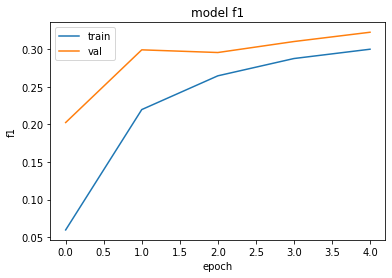

In [38]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Теперь 16 слоев и сократим размерность эмбеддингов

In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(symb2id), output_dim=50)(inputs, )
convs = []

conv1 = tf.keras.layers.Conv1D(kernel_size=2, filters=24, strides=1)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=1, filters=16, strides=1, activation='relu')(conv1)
pool1 = tf.keras.layers.GlobalMaxPooling1D()(conv2)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)
convs.append(drop1)

conv3 = tf.keras.layers.Conv1D(kernel_size=4, filters=32, strides=1)(embeddings)
conv4 = tf.keras.layers.Conv1D(kernel_size=2, filters=28, strides=1)(conv3)
conv5 = tf.keras.layers.Conv1D(kernel_size=1, filters=16, strides=1)(conv4)
pool2 = tf.keras.layers.GlobalMaxPooling1D()(conv5)
convs.append(pool2)

conv6 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=1)(embeddings)
conv7 = tf.keras.layers.Conv1D(kernel_size=3, filters=14, strides=1)(conv6)
conv8 = tf.keras.layers.Conv1D(kernel_size=2, filters=16, strides=1)(conv7)
drop2 = tf.keras.layers.GlobalMaxPooling1D()(conv8)
convs.append(drop2)



conv9 = tf.keras.layers.Conv1D(kernel_size=6, filters=32, strides=1)(embeddings)
conv10 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(conv9)
conv11 = tf.keras.layers.Conv1D(kernel_size=4, filters=32, strides=1)(conv10)
conv12 = tf.keras.layers.Conv1D(kernel_size=3, filters=16, strides=1)(conv11)
drop3 = tf.keras.layers.GlobalMaxPooling1D()(conv12)
convs.append(drop3)


concat = tf.keras.layers.concatenate(convs)

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [45]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=8000,
         epochs=5)

Epoch 1/5
156/156 [==============================] - 712s 5s/step - loss: 0.2428 - f1: 7.8871e-04 - val_loss: 0.2030 - val_f1: 0.0000e+00
Epoch 2/5
156/156 [==============================] - 711s 5s/step - loss: 0.1851 - f1: 0.0887 - val_loss: 0.1748 - val_f1: 0.1993
Epoch 3/5
156/156 [==============================] - 710s 5s/step - loss: 0.1669 - f1: 0.2506 - val_loss: 0.1668 - val_f1: 0.3008
Epoch 4/5
156/156 [==============================] - 704s 5s/step - loss: 0.1603 - f1: 0.2990 - val_loss: 0.1626 - val_f1: 0.2490
Epoch 5/5
156/156 [==============================] - 696s 4s/step - loss: 0.1568 - f1: 0.3225 - val_loss: 0.1597 - val_f1: 0.2885


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


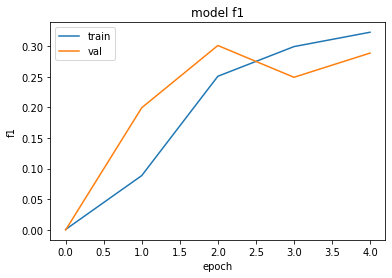

In [46]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Увеличим число эпох

In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(symb2id), output_dim=50)(inputs, )
convs = []

conv1 = tf.keras.layers.Conv1D(kernel_size=2, filters=24, strides=1)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=1, filters=16, strides=1, activation='relu')(conv1)
pool1 = tf.keras.layers.GlobalMaxPooling1D()(conv2)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)
convs.append(drop1)


conv3 = tf.keras.layers.Conv1D(kernel_size=4, filters=32, strides=1)(embeddings)
conv4 = tf.keras.layers.Conv1D(kernel_size=2, filters=28, strides=1)(conv3)
conv5 = tf.keras.layers.Conv1D(kernel_size=1, filters=16, strides=1)(conv4)
pool2 = tf.keras.layers.GlobalMaxPooling1D()(conv5)
convs.append(pool2)

conv6 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=1)(embeddings)
conv7 = tf.keras.layers.Conv1D(kernel_size=3, filters=14, strides=1)(conv6)
conv8 = tf.keras.layers.Conv1D(kernel_size=2, filters=16, strides=1)(conv7)
drop2 = tf.keras.layers.GlobalMaxPooling1D()(conv8)
convs.append(drop2)



conv9 = tf.keras.layers.Conv1D(kernel_size=6, filters=32, strides=1)(embeddings)
conv10 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(conv9)
conv11 = tf.keras.layers.Conv1D(kernel_size=4, filters=32, strides=1)(conv10)
conv12 = tf.keras.layers.Conv1D(kernel_size=3, filters=16, strides=1)(conv11)
drop3 = tf.keras.layers.GlobalMaxPooling1D()(conv12)
convs.append(drop3)


concat = tf.keras.layers.concatenate(convs)

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [48]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
         epochs=10)

Epoch 1/10
311/311 [==============================] - 731s 2s/step - loss: 0.2105 - f1: 0.0352 - val_loss: 0.1783 - val_f1: 0.1630
Epoch 2/10
311/311 [==============================] - 735s 2s/step - loss: 0.1678 - f1: 0.2354 - val_loss: 0.1635 - val_f1: 0.2372
Epoch 3/10
311/311 [==============================] - 737s 2s/step - loss: 0.1588 - f1: 0.3026 - val_loss: 0.1594 - val_f1: 0.3201
Epoch 4/10
311/311 [==============================] - 737s 2s/step - loss: 0.1544 - f1: 0.3354 - val_loss: 0.1586 - val_f1: 0.3734
Epoch 5/10
311/311 [==============================] - 728s 2s/step - loss: 0.1513 - f1: 0.3566 - val_loss: 0.1551 - val_f1: 0.3361
Epoch 6/10
311/311 [==============================] - 728s 2s/step - loss: 0.1493 - f1: 0.3654 - val_loss: 0.1547 - val_f1: 0.3056
Epoch 7/10
311/311 [==============================] - 729s 2s/step - loss: 0.1477 - f1: 0.3750 - val_loss: 0.1547 - val_f1: 0.3076
Epoch 8/10
311/311 [==============================] - 738s 2s/step - loss: 0.1465 -

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


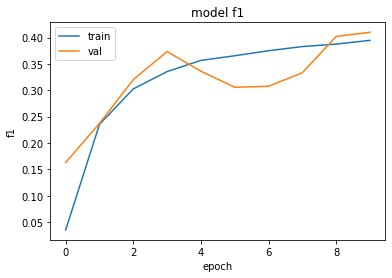

In [49]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Попробуем теперь оставить только алфавитные символы

In [0]:
alphabet = string.ascii_letters

In [0]:
def tokenize (text):
  symbols = []
  for symb in text:
    if symb in alphabet:
      symbols += [symb]  
  return symbols

In [0]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(tokenize(text))

In [17]:
len(vocab)

52

In [0]:
symb2id = {'UNK':1, 'PAD':0}

for symb in vocab:
    symb2id[symb] = len(symb2id)

id2symb = {i:symb for symb, i in symb2id.items()}

In [0]:
X = []

for text in quora.question_text:
    tokens = tokenize(text)
    ids = [symb2id.get(token, 1) for token in tokens]
    X.append(ids)

In [0]:
MEAN_LEN = np.median([len(x) for x in X])

In [0]:
MAX_LEN = int(MEAN_LEN) + 5

In [0]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [25]:
X.shape

(1306122, 54)

In [0]:
y = quora.target.values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', 
                                                monitor='val_f1',
                                                verbose=1,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                mode='max',
                                                save_freq='epoch')

In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(symb2id), output_dim=50)(inputs, )
convs = []

conv1 = tf.keras.layers.Conv1D(kernel_size=2, filters=24, strides=1)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=1, filters=16, strides=1, activation='relu')(conv1)
pool1 = tf.keras.layers.GlobalMaxPooling1D()(conv2)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)
convs.append(drop1)

conv3 = tf.keras.layers.Conv1D(kernel_size=4, filters=32, strides=1)(embeddings)
conv4 = tf.keras.layers.Conv1D(kernel_size=2, filters=28, strides=1)(conv3)
conv5 = tf.keras.layers.Conv1D(kernel_size=1, filters=16, strides=1)(conv4)
pool2 = tf.keras.layers.GlobalMaxPooling1D()(conv5)
convs.append(pool2)

conv6 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=1)(embeddings)
conv7 = tf.keras.layers.Conv1D(kernel_size=3, filters=14, strides=1)(conv6)
conv8 = tf.keras.layers.Conv1D(kernel_size=2, filters=16, strides=1)(conv7)
drop2 = tf.keras.layers.GlobalMaxPooling1D()(conv8)
convs.append(drop2)



conv9 = tf.keras.layers.Conv1D(kernel_size=6, filters=32, strides=1)(embeddings)
conv10 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(conv9)
conv11 = tf.keras.layers.Conv1D(kernel_size=4, filters=32, strides=1)(conv10)
conv12 = tf.keras.layers.Conv1D(kernel_size=3, filters=16, strides=1)(conv11)
drop3 = tf.keras.layers.GlobalMaxPooling1D()(conv12)
convs.append(drop3)


concat = tf.keras.layers.concatenate(convs)

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [31]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
         epochs=10)

Epoch 1/10
311/311 [==============================] - 580s 2s/step - loss: 0.2195 - f1: 0.0110 - val_loss: 0.1883 - val_f1: 0.0278
Epoch 2/10
311/311 [==============================] - 584s 2s/step - loss: 0.1784 - f1: 0.1457 - val_loss: 0.1699 - val_f1: 0.2149
Epoch 3/10
311/311 [==============================] - 583s 2s/step - loss: 0.1677 - f1: 0.2436 - val_loss: 0.1650 - val_f1: 0.2339
Epoch 4/10
311/311 [==============================] - 582s 2s/step - loss: 0.1633 - f1: 0.2750 - val_loss: 0.1618 - val_f1: 0.2856
Epoch 5/10
311/311 [==============================] - 583s 2s/step - loss: 0.1605 - f1: 0.2916 - val_loss: 0.1613 - val_f1: 0.3123
Epoch 6/10
311/311 [==============================] - 582s 2s/step - loss: 0.1586 - f1: 0.3037 - val_loss: 0.1588 - val_f1: 0.3118
Epoch 7/10
311/311 [==============================] - 582s 2s/step - loss: 0.1570 - f1: 0.3142 - val_loss: 0.1582 - val_f1: 0.3479
Epoch 8/10
311/311 [==============================] - 581s 2s/step - loss: 0.1557 -

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


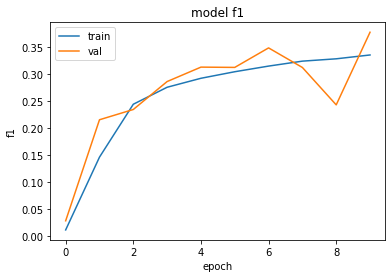

In [32]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

С алфавитными символами стало немного хуже